### User Inputs

In [1]:
retailer = 'pure'
sql = 'pure_txns.sql'
offer_name = 'free coffee yellow'
measurement_period = ''

### Packages and definitions needed for python 

In [2]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import plotly.express as px
import psutil
from datetime import datetime, timedelta

path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

### Read in transactions for retailer

In [105]:
#read in pure data from SQL query:
start = time.time()
df = query_from_file(sql)
end = time.time()
query_time = end-start
print(f"Query took {query_time:.2f} seconds")

Query took 4.67 seconds


### Data pre-processing
- Creates new **date** variables that will be useful

In [106]:
#additional date columns that will be useful 
df['date'] = df['transaction_date'].dt.date
df['day'] = df['transaction_date'].dt.isocalendar().day
df['week'] = df['transaction_date'].dt.isocalendar().week
df['week_start'] = (df['transaction_date'] - pd.TimedeltaIndex(df['transaction_date'].dt.dayofweek, unit='D')).dt.date
df['month'] = df['transaction_date'].dt.month

- Change data types where necessary

In [107]:
#change price to a numeric variable 
df['price'] = pd.to_numeric(df['item_price'])

- Creates a variable that indicates the **receipt number** for that customer
- This will be used to segments new and existing customers
- Warning - we can only see if they are new customers within Flux, so they may have a receipt count of 1 even though transacted before 

In [108]:
df_receipts = df[['customer_id','receipt_id','total_amount','transaction_date','date','month','week','location_id']].drop_duplicates().sort_values(['customer_id','transaction_date'])
df_receipts['receipt_count'] = df_receipts.groupby(['customer_id'])['receipt_id'].cumcount()+1
df = pd.merge(df, df_receipts[['receipt_count','customer_id','receipt_id']], on = ['customer_id','receipt_id'], how = 'left' )

- identify transactions on the chosen offer
- save the receipts containing the offer to an array to reference another time

In [109]:
df_offer = df[df['name'] == 'Free Coffee YELLOW'].copy()
redemption_receipts = df_offer['receipt_id'].unique()
redeemers = df_offer['customer_id'].unique()
redemption_count = len(redemption_receipts)
redeemer_count = len(redeemers)

- assign start and end dates of the offer to objects to reference in code
- assign the number of days, weeks and months an offer was live for to objects to reference in code

In [110]:
date_min = df_offer['date'].min()
date_max = df_offer['date'].max()
days_live = (date_max - date_min).days
weeks_live = round(np.floor(days_live/7))
months_live = round(np.floor(weeks_live/4))

- identify all transactions at retailer while the offer was live
- segment customers that transacted during the offer period into customers acquired on offer and previous customers = acquired_previous
- segment customers that transacted into new and existing before the offer period start date = new_existing
- segment customers into customers that redeemed the offer or not
- also going to provide a view of acquired, new_not_acquired, existing

In [111]:
df_live = df[(df['date']<=date_max) & (df['date']>=date_min)].copy()

new_customers = df_live[df_live.receipt_count== 1].customer_id.unique()
acquired_customers = df_live[(df_live['receipt_id'].isin(redemption_receipts))& (df_live.receipt_count==1)]['customer_id'].unique()

df_live['redemption_segment'] = np.where(df_live['customer_id'].isin(redeemers),'redeemer','non-redeemer')
df_live['acquired_previous'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired','previous')
df_live['new_existing'] = np.where(df_live['customer_id'].isin(new_customers),'new','existing')
df_live['acquired_new_existing'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired',df_live['new_existing'])
df_live['acquired_new_existing'] = df_live['acquired_new_existing'].str.replace('new','new_not_acquired')

- create a df that holds only the receipt information and not the sku data too, with segments included

In [112]:
df_live_receipts = df_live[['customer_id', 'receipt_id', 'total_amount', 'price', 'redemption_segment', 'acquired_previous', 'new_existing', 'acquired_new_existing','transaction_date','receipt_count','date','week_start']].copy().drop_duplicates()

- add in a variable that holds **basket size**
- don't want to include in basket size any freebies or £0 items, such as the milk chosen, or any discounts that aren't an item, such as 50p off for using a reusable cup
- it is tricky because the true offers, such as free coffe first appear as an item and then the price is taken off. 
- The item price being taken off should match that provided on the receipt for it to be an offer and not just a discounts, e.g. reusable cup 50p

In [113]:
# add a receipt_price_count variable, so can flag if multiple used on one receipt
df['receipt_price_count'] = df.groupby(['receipt_id','price']).cumcount()+1
#identify the discounts
discounts = pd.DataFrame(df[df['price']<0][['receipt_id','price','receipt_price_count']])
discounts['price'] = discounts['price']*-1
discounts['offer_flag'] = '1'
#reattach the discounts onto transactions to match the item where freebie has been given
#now anything bought on an offer should be flagged 
df = pd.merge(df, discounts, on=['receipt_id','price','receipt_price_count'], how = 'left')
df.fillna('0', inplace = True)
#count the paid-for items on each receipt
#this will still include the initial proe of items that were taken off the final receipt
receipt_item_count = pd.DataFrame(df[(df['price']>0) & (df['offer_flag']=='0')].groupby('receipt_id').count()['item_id']).reset_index()
receipt_item_count.columns = ['receipt_id','adjusted_basket_size']
#attach onto receipts from the offer period
df_live = pd.merge(df_live,receipt_item_count, on = 'receipt_id',how = 'left') 
df_live.fillna(0, inplace = True)

# Results
### Segment counts

In [114]:
customer_receipt_counts = df_live.groupby(['redemption_segment','acquired_previous','new_existing']).nunique()[['customer_id','receipt_id']]
customer_receipt_counts.columns = ['unique customers','unique receipts']
customer_receipt_counts

unique customers  \
redemption_segment acquired_previous new_existing                     
non-redeemer       previous          existing                  3134   
                                     new                       3896   
redeemer           acquired          new                         22   
                   previous          existing                    91   
                                     new                         44   

                                                   unique receipts  
redemption_segment acquired_previous new_existing                   
non-redeemer       previous          existing                13922  
                                     new                      6741  
redeemer           acquired          new                        54  
                   previous          existing                 1229  
                                     new                       488

### Segment percentages

- What percent of customers using the offer are acquired customers vs customers that had already transacted at the retailer?

In [115]:
customer_pcent = (customer_receipt_counts.loc['redeemer']['unique customers']/(customer_receipt_counts.loc['redeemer']['unique customers'].sum()))*100
print('The % split of redeemers by customer segment is:')
print(customer_pcent)

The % split of redeemers by customer segment is:
acquired_previous  new_existing
acquired           new             14.012739
previous           existing        57.961783
                   new             28.025478
Name: unique customers, dtype: float64


- what % of customers transacting per week at the retailer are new that week vs previous?
- use the previous 4 weeks worth of transactions prior to the offer
- we will use this as a baseline to compare the offer to

In [116]:
df_pre = df_receipts[df_receipts.date < date_min].copy()
baseline_pre = df_pre[df_pre['receipt_count']==1].groupby(['week','receipt_count']).nunique()[['customer_id']]/df_pre.groupby('week').nunique()[['customer_id']].tail(4)
baseline_new_pcent = baseline_pre['customer_id'].mean()*100
print(f'The baseline of transacting customers that are new per week is: {baseline_new_pcent:.2f}%')

The baseline of transacting customers that are new per week is: 51.63%


- *would be good here to know how much this varies - does the offer fall between 2sd of the ussual % customers? Is is truly different? or do we only care about having a comparison?*
- *or some sort of significance test*

In [129]:
#grab counts, ATF, ATV  and Basket Size per group 

#first group by customer
agg = df_live.groupby(['redemption_segment','acquired_previous','new_existing','customer_id']).agg({'receipt_id':['nunique']
                                                                                        ,'total_amount':['sum','mean']
                                                                                        ,'adjusted_basket_size':['mean']})
agg.columns=agg.columns.map('_'.join)
agg.columns = ['frequency','total_amount','amount','adjusted_basket_size']
agg.reset_index(inplace = True)
#then grab metrics
agg2 = agg.groupby(['redemption_segment','acquired_previous','new_existing']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })
agg2.columns=agg2.columns.map('_'.join)
agg2['weekly_ATF'] = agg2['frequency_median']/(days_live/7)
agg2['yearly_ATF'] = (agg2['frequency_median']/(days_live))*365
agg2['ATF_offer_period'] = agg2['frequency_median']
agg2['ATV'] = agg2['amount_median']/100 #using median as less sensitive to outliers
agg2['weekly_ACV'] = (agg2['total_amount_median']/(days_live/7))/100
agg2['ACV_offer_period'] = (agg2['total_amount_median'])/100
agg2['ABS'] = agg2['adjusted_basket_size_median']
summary_metrics = agg2[['customer_id_nunique','weekly_ATF','ATF_offer_period','ATV','weekly_ACV','ACV_offer_period','ABS','yearly_ATF']]
summary_metrics
#note haven't separated out the custoomers acquired ON the offer here
#treating new customers during offer measurement period as all new even iff not acquired on the offer
#this is easier to measure
#just need to make sure it is clesar when displaying

customer_id_nunique  \
redemption_segment acquired_previous new_existing                        
non-redeemer       previous          existing                     3134   
                                     new                          3896   
redeemer           acquired          new                            22   
                   previous          existing                       91   
                                     new                            44   

                                                   weekly_ATF  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.029167   
                                     new             0.014583   
redeemer           acquired          new             0.021875   
                   previous          existing        0.131250   
                                     new             0.087500   

                                                   ATF_offer_period       ATV  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                   2.0  5.118333   
                                     new                        1.0  4.950000   
redeemer           acquired          new                        1.5  3.411000   
                   previous          existing                   9.0  4.550000   
                                     new                        6.0  5.074308   

                                                   weekly_ACV  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.252219   
                                     new             0.129573   
redeemer           acquired          new             0.280875   
                   previous          existing        0.926042   
                                     new             1.188031   

                                                   ACV_offer_period       ABS  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                17.295  1.500000   
                                     new                      8.885  1.000000   
redeemer           acquired          new                     19.260  1.000000   
                   previous          existing                63.500  1.470588   
                                     new                     81.465  1.650433   

                                                   yearly_ATF  
redemption_segment acquired_previous new_existing              
non-redeemer       previous          existing        1.520833  
                                     new             0.760417  
redeemer           acquired          new             1.140625  
                   previous          existing        6.843750  
                                     new             4.562500

## Redemptions Card

In [160]:
#all redemptions
total_redemptions = len(df_offer)
#all redeemers
total_cust = agg2.loc['redeemer'].customer_id_nunique.sum()
#redemptions per customer
redemptions_per_customer = total_redemptions/total_cust

#previous retailer customers
previous_volume = agg2.loc['redeemer'].loc['previous'].customer_id_nunique.sum()
#retailer acquisitions - made first transacgion on the offer
acquisitions_volume = df_live[df_live.acquired_previous == 'acquired']['customer_id'].nunique()
#total new customers
new_volume = df_live[df_live.new_existing == 'new']['customer_id'].nunique()

#percentages
previous_pcent = (previous_volume/total_cust)*100
acquisitions_pcent = (acquisitions_volume/total_cust)*100
new_pcent = (new_volume/total_cust)*100
baseline_diff = new_cust_pcent - baseline_new_pcent

#print results
print(f'The total number of redemptions =  {total_redemptions}')
print(f'The total number of unique customers that used the offer = {total_cust}')
print(f'The numer of redemptions per customer = {redemptions_per_customer:.2f}')
print('\n')
print(f'{acquisitions_pcent:.0f}% of redeemers ({acquisitions_volume} customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer')
print(f'{previous_pcent:.0f}% of redeemers are previous customers')
print('\n')
print(f'The baseline % of weekly new customers is {baseline_new_pcent:.2f}% \n(This is the average % of customers that are new based on 4 weeks pre offer start)')
print(f'The % of weekly new customers during the offer period is {new_pcent:.2f}% ')
print('\n')
print(f'Offer redeemers have an absolute % difference of {baseline_diff:.0f}% new customers compared to the baseline')

The total number of redemptions =  308
The total number of unique customers that used the offer = 157
The numer of redemptions per customer = 1.96


14% of redeemers (22 customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer
86% of redeemers are previous customers


The baseline % of weekly new customers is 51.63% 
(This is the average % of customers that are new based on 4 weeks pre offer start)
The % of weekly new customers during the offer period is 2523.57% 


Offer redeemers have an absolute % difference of -38% new customers compared to the baseline


## Frequency Metrics

In [161]:
summary_metrics

customer_id_nunique  \
redemption_segment acquired_previous new_existing                        
non-redeemer       previous          existing                     3134   
                                     new                          3896   
redeemer           acquired          new                            22   
                   previous          existing                       91   
                                     new                            44   

                                                   weekly_ATF  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.029167   
                                     new             0.014583   
redeemer           acquired          new             0.021875   
                   previous          existing        0.131250   
                                     new             0.087500   

                                                   ATF_offer_period       ATV  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                   2.0  5.118333   
                                     new                        1.0  4.950000   
redeemer           acquired          new                        1.5  3.411000   
                   previous          existing                   9.0  4.550000   
                                     new                        6.0  5.074308   

                                                   weekly_ACV  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.252219   
                                     new             0.129573   
redeemer           acquired          new             0.280875   
                   previous          existing        0.926042   
                                     new             1.188031   

                                                   ACV_offer_period       ABS  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                17.295  1.500000   
                                     new                      8.885  1.000000   
redeemer           acquired          new                     19.260  1.000000   
                   previous          existing                63.500  1.470588   
                                     new                     81.465  1.650433   

                                                   yearly_ATF  
redemption_segment acquired_previous new_existing              
non-redeemer       previous          existing        1.520833  
                                     new             0.760417  
redeemer           acquired          new             1.140625  
                   previous          existing        6.843750  
                                     new             4.562500

In [171]:
days_live

480

In [170]:
f_metrics = summary_metrics['weekly_ATF']

#we want ot aggreate just for redemption segment
#using median so that result is insensitive to outlier customers
ATF_redeemer = agg[agg['redemption_segment']=='redeemer']['frequency'].median()
ATF_non_redeemer = agg[agg['redemption_segment']=='non-redeemer']['frequency'].median()

ATF_redeemer_weekly = agg[agg['redemption_segment']=='redeemer']['frequency'].median()/(days_live/7)
ATF_non_redeemer_weekly = agg[agg['redemption_segment']=='non-redeemer']['frequency'].median()/(days_live/7)

print(f'Redeemers of the offer transacted on average {ATF_redeemer:.0f} times during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer:.0f} times during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly:.3f} times PER WEEK during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly:.3f} times PER WEEK during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly*52:.1f} times over a projected year')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly*52:.1f} times over a projected year')
print('\n')
print('More detailed breakdown of weekly ATF:')
print(f_metrics)
print('\n')

Redeemers of the offer transacted on average 6 times during the offer period
Non-redeemers of the offer transacted on average 1 times during the offer period


Redeemers of the offer transacted on average 0.088 times PER WEEK during the offer period
Non-redeemers of the offer transacted on average 0.015 times PER WEEK during the offer period


Redeemers of the offer transacted on average 4.6 times over a projected year
Non-redeemers of the offer transacted on average 0.8 times over a projected year


More detailed breakdown of weekly ATF:
redemption_segment  acquired_previous  new_existing
non-redeemer        previous           existing        0.029167
                                       new             0.014583
redeemer            acquired           new             0.021875
                    previous           existing        0.131250
                                       new             0.087500
Name: weekly_ATF, dtype: float64




## Retention graph

- Want to look at acquisitions vs those that are new in the time period to compare the repeat purcahse rate
- Give view of how many made repeat purcahses

In [208]:
#grab the customers in two segments:
df_repeat_subset = df_live[df_live.new_existing == 'new'][['acquired_previous','customer_id','date','receipt_count']].copy()
#acquisitions
df_repeat_subset['lagged_date'] = df_repeat_subset.sort_values(by = ['customer_id','date'],ascending = True).groupby('customer_id')['date'].shift(1)
df_repeat_subset['date_diff'] = (df_repeat_subset['date'] - df_repeat_subset['lagged_date']).dt.days
df_repeat_subset['week_diff'] = np.ceil(df_repeat_subset.date_diff/7)

- over 12 weeks what % of acquired vs new not acquired made repeat purcahses?
- volumes:

In [223]:
#restrict to 12 weeks after their first transaction
df_repeat = df_repeat_subset[df_repeat_subset['week_diff']<12].groupby(['acquired_previous','receipt_count']).nunique()['customer_id'].unstack()
df_repeat[[1,2,3,4,5,6,7,8,9,10]].fillna(0)

receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,22.0,11.0,7.0,4.0,4.0,2.0,2.0,1.0,1.0,0.0
previous,1775.0,990.0,525.0,328.0,222.0,170.0,127.0,95.0,81.0,70.0


- as a percentage of those in each group:

In [224]:
df_repeat.div(df_repeat[1], axis=0)[[1,2,3,4,5,6,7,8,9,10]].fillna(0)*100

receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,100.0,50.000000,31.818182,18.181818,18.181818,9.090909,9.090909,4.545455,4.545455,0.000000
previous,100.0,55.774648,29.577465,18.478873,12.507042,9.577465,7.154930,5.352113,4.563380,3.943662


## Revenue Impact

### Existing customers

In [229]:
#during offer period
during_spend = agg[agg['new_existing']=='existing'].groupby('redemption_segment').agg({'total_amount':['mean','median','sum']})

#pre offer period
#first need to know the redemption segments they ended up in 
offer_period_segs = agg[['customer_id','redemption_segment']].drop_duplicates()
#by definition all customers in the pre offer period are in the existing segment but will need to attach on redemption segment to pre transactions
pre_offer_transactions = df[df['date']<date_min][['customer_id','receipt_id','total_amount','date','updated_date']].drop_duplicates()
pre_offer_seg = pd.merge(pre_offer_transactions,offer_period_segs, on = 'customer_id',how = 'left')
pre_offer_seg.fillna(0, inplace = True)
pre_spend = pre_offer_seg.groupby('redemption_segment').agg({'total_amount':['mean','median','sum']})
#need to be carefull here with null values -> where customers do not transact in offer period 
#and with what type of average being used
print(pre_spend)
print(during_spend)

#divide by the number of days the offer period was live and the number of days of pre period to make comparable
pre_days = (df_live.date.min() - pre_offer_transactions.date.min()).days

print('\n')
print(f'The number of days in the pre period is {pre_days}')
print(f'The number of days in the offer period is {days_live}')
print('\n')
print('Total amount per days pre:')
pre_spend_daily = pre_spend/pre_days
print(pre_spend_daily)
print('\n')
print('Total amount per days offer:')
during_spend_daily = during_spend/days_live
print(during_spend_daily)

                   total_amount                   
                           mean median         sum
redemption_segment                                
0                    514.834833  485.0   8924147.0
non-redeemer         512.654852  485.0  14579904.0
redeemer             474.567586  385.0    705682.0
                    total_amount                    
                            mean  median         sum
redemption_segment                                  
non-redeemer         4311.074027  1729.5  13510906.0
redeemer            13329.274725  6350.0   1212964.0


The number of days in the pre period is 382
The number of days in the offer period is 480


Total amount per days pre:
                   total_amount                        
                           mean    median           sum
redemption_segment                                     
0                      1.347735  1.269634  23361.641361
non-redeemer           1.342028  1.269634  38167.287958
redeemer               1.242

In [230]:
#calculate change in spend for redeemers and non-redeemers
redeemer_change = during_spend_daily['total_amount']['median']['redeemer'] - pre_spend_daily['total_amount']['median']['redeemer']
pcent_redeemer_change = redeemer_change/(pre_spend_daily['total_amount']['median']['redeemer'])

non_redeemer_change = during_spend_daily['total_amount']['median']['non-redeemer'] - pre_spend_daily['total_amount']['median']['non-redeemer']
pcent_non_redeemer_change = non_redeemer_change/(pre_spend_daily['total_amount']['median']['non-redeemer'])

if pcent_redeemer_change**2 > pcent_non_redeemer_change**2:
    larger_smaller = 'larger'
else: 
    larger_smaller = 'smaller'
    
if pcent_redeemer_change > 0:
    increase_decrease = 'increase'
else:
    increase_decrease = 'decrease'

incr_pcent = pcent_redeemer_change-pcent_non_redeemer_change
avg_pre_spend_redeemer = pre_spend_daily['total_amount']['median']['redeemer']/100
incr_spend = (avg_pre_spend_redeemer * incr_pcent)

print('Existing Customers \n')
print(f'The redeemers of the offer have a {larger_smaller} proportional {increase_decrease} in daily average spend than the non-redeemers between the pre period and offer period')
print(f'The perentage change in spend between periods is {pcent_redeemer_change*100:.0f}% in the redeemer group & {pcent_non_redeemer_change*100:.0f}% in the non-redeemer group')
print(f'Incremental accounts for {incr_pcent*100:.0f}% of spend in the redeemer group')
print(f'The average pre spend per redeemer per day was £{avg_pre_spend_redeemer:.2f}, resulting in a daily incremental spend per redeemer of £{incr_spend:.2f}')
#incr_spend_total = incr_spend*total_cust*(during_days/pre_days)
incr_spend_total = incr_spend*total_cust*30
print(f'Over the offer measurement period of {30} days, this is a total incremental spend of £{incr_spend_total:.0f} across the {existing_cust} customers')
print(f'Or £{(incr_spend_total/existing_cust):.2f} per customer')

Existing Customers 

The redeemers of the offer have a larger proportional increase in daily average spend than the non-redeemers between the pre period and offer period
The perentage change in spend between periods is 1213% in the redeemer group & 184% in the non-redeemer group
Incremental accounts for 1029% of spend in the redeemer group
The average pre spend per redeemer per day was £0.01, resulting in a daily incremental spend per redeemer of £0.10
Over the offer measurement period of 30 days, this is a total incremental spend of £488 across the 135.0 customers
Or £3.62 per customer


In [231]:
from utils import style
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Akkurat Pro'
matplotlib.rcParams['font.serif'] = 'Vesterbro'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = '15'

matplotlib.rcParams['figure.figsize'] = (50, 15)
matplotlib.rcParams['figure.titlesize'] = '25'

matplotlib.rcParams['axes.titlesize'] = '25'
matplotlib.rcParams['axes.labelsize'] = '15'
matplotlib.rcParams['axes.titlepad'] = '25'
matplotlib.rcParams['axes.labelpad'] = '30'
matplotlib.rcParams['xtick.labelsize'] = '15'
matplotlib.rcParams['ytick.labelsize'] = '20'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


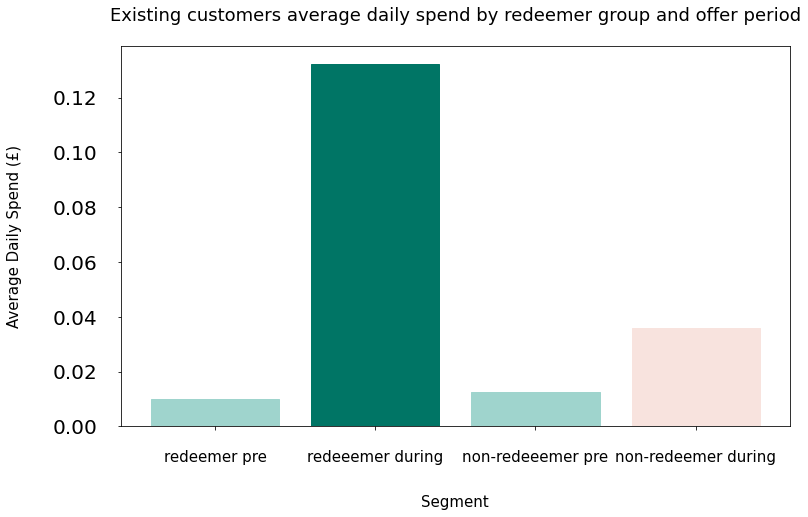

In [232]:
#quick plot of difference to help understanding
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
rp = pre_spend_daily['total_amount']['median']['redeemer']/100
rd = during_spend_daily['total_amount']['median']['redeemer']/100
nrp = pre_spend_daily['total_amount']['median']['non-redeemer']/100
nrd = during_spend_daily['total_amount']['median']['non-redeemer']/100
x = ['redeemer pre','redeeemer during','non-redeeemer pre','non-redeemer during']
y = pd.Series([rp,rd,nrp,nrd])

chart = plt.bar(x,y)
chart[0].set_color('mint')
chart[1].set_color('green')
chart[2].set_color('mint')
chart[3].set_color('pink')
plt.title('Existing customers average daily spend by redeemer group and offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

*Is the difference significant?*

### New customers

In [237]:
#want to find out the average number of days each new customer was active for in the measurement period
new_cust_first_txn = df_live[(df_live.new_existing=='new')&(df_live['receipt_count']==1)][['customer_id','date','redemption_segment']].copy()
#work uot at what point in the measurement period, the new customer joined and began transacting 
new_cust_first_txn['days_active'] = (date_max - new_cust_first_txn['date']).astype('timedelta64[D]')
#what is the average active days for new customers in each redemption group 
new_days_active = new_cust_first_txn.groupby('redemption_segment').agg({'days_active':['mean','median']})

# *** Tidied up to here ***

In [ ]:
#new customers spend 

#during offer period
during_spend_new = agg[agg['new_segment']=='new'].groupby('offer_segment').agg({'total_amount':['mean','median','sum']})
daily_avg_spend_new = during_spend_new['total_amount']['median']/new_days_active['days_active']['median']
daily_incr_new = (daily_avg_spend_new['redeemer'] - daily_avg_spend_new['non-redeemer'])/100
incr_spend_new = daily_incr_new*new_cust*30

print(f'For new customers, daily average incremetal spend was £{daily_incr_new:.2f} in the redeemer group')
print(f'')
print(f'Over the offer measurement period of {30} days, this is a total incremental spend of £{incr_spend_new:.2f} across the {new_cust:.0f} customers')
print(f'Or £{incr_spend_new/new_cust:.2f} per customer')

In [ ]:
#quick plot of difference to help understanding

plt.figure(figsize = (12,7))
rd = daily_avg_spend_new['redeemer']/100
nrd = daily_avg_spend_new['non-redeemer']/100
x = ['redeemer','non-redeeemer']
y = pd.Series([rd,nrd])

chart = plt.bar(x,y)
chart[0].set_color('green')
chart[1].set_color('pink')
plt.title('New customers average daily spend during the offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

## Acquired customers

In [ ]:
df_acq_txns['lagged_date'] = df_acq_txns.groupby('customer_id')['date'].shift(1)
df_acq_txns['date_diff'] = (df_acq_txns['date'] - df_acq_txns['lagged_date']).dt.days
df_acq_txns['week_diff'] = np.ceil(df_acq_txns.date_diff/7)

In [ ]:
acq = agg[agg['new_segment']=='acquired']
first_date = pd.DataFrame(df_during[df_during['new_segment']=='acquired'].groupby('customer_id').date.min())
new_df = pd.merge(acq,first_date, on = 'customer_id', how = 'left')
new_df['max_date'] = date_max
new_df['date_diff'] = (new_df.max_date - new_df.date).dt.days
roi_monthly_total = ((new_df['total_amount']/new_df['date_diff'])*30).sum()
roi_monthly_avg = ((new_df['total_amount']/new_df['date_diff'])*30).mean()

print(roi_monthly_total)
print(roi_monthly_avg)

#need the number of days they were active = max-date - first_transaction_date
#calcaulte total monthly spend 
#monthly spend = ROI contribution

In [ ]:
agg[agg['new_segment']=='acquired'].nunique()['customer_id']

In [ ]:
agg[agg['new_segment']=='acquired']['total_amount'].sum()

In [ ]:
during_spend_acquired = agg[agg['new_segment']=='acquired']['total_amount'].sum()
acquired_cust = agg[agg['new_segment']=='acquired'].nunique()['customer_id']

print(f'For aquired customers, all spend is attributed to the offer')
print(f'Assumption is that the offer drove them to start transacting with the retailer')
print('\n')
print(f'Over the offer measurement period of {during_days} days, this is a total spend of £{during_spend_acquired:.2f} across the {acquired_cust:.0f} customers')
print(f'Or £{during_spend_acquired/acquired_cust:.2f} per customer')
print(f'Or £{(during_spend_acquired/acquired_cust)/d:.2f} per customer per day')

### Total Revenue

In [ ]:
total_incr_rev = incr_spend_new + incr_spend_total 
total_incr_rev_cust = total_incr_rev/total_cust

print(f'The total incremental revenue from this offer over the measurement period is £{total_incr_rev:.0f}')
print(f'Per redeemer this is £{total_incr_rev_cust:.2f}')

### Total Cost

In [ ]:
#= sum of redeemer price 
redeemer_receipts_during = df_during[df_during.new_segment.isin(['new','existing'])]['receipt_id'].unique()

total_cost = (df_off[df_off['receipt_id'].isin(redeemer_receipts_during)]['price']*-1).sum()/100
total_cost_cust = total_cost/total_cust

print(f'The total discount given out over the offer measurement period is £{total_cost}')
print(f'Per redeemer this is £{total_cost_cust:.2f}')

# Cost acquired only

In [ ]:
#cost for acquired:


redeemer_receipts_during = df_during[df_during['new_segment'] == 'acquired']['receipt_id'].unique()

total_cost_acq = (df_off[df_off['receipt_id'].isin(redeemer_receipts_during)]['price']*-1).sum()/100
total_cost_cust_acq = total_cost/total_cust

print(f'The total discount given out over the offer measurement period is £{total_cost}')
print(f'Per redeemer this is £{total_cost_cust:.2f}')

# ROI acquired only

In [ ]:
print(f'Acquired customers monthly revenue is £{roi_monthly_total:.2f}')
print(f'Acquired customers cost is £{total_cost_acq:.2f}')

print((roi_monthly_total - total_cost_acq))

ROI_acq = (roi_monthly_total/total_cost_acq)
print(f'Return on investment is {ROI_acq:.2f}')

## ROI not acquired

In [ ]:
ROI = (total_incr_rev/total_cost)


print((total_incr_rev - total_cost))

print(f'Previous customers monthly increase in revenue is £{total_incr_rev:.2f}')
print(f'Previous customers cost is £{total_cost:.2f}')
print(f'Return on investment is {ROI:.2f}')

## ATV

In [ ]:
v_metrics = agg2['ATV']

agg
ATV_redeemer = agg[agg['offer_segment']=='redeemer']['amount'].median()/100
ATV_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['amount'].median()/100

print(f'Redeemers have an average transaction value of £{ATV_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average transaction value of £{ATV_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of ATV:')
print(v_metrics)
print('\n')

In [ ]:
#average transaction value of redemmers total is :
agg[agg['offer_segment']=='redeemer']['amount'].median()/100

In [ ]:
agg['prev_segment']= np.where(agg['new_segment'].isin(['existing','new']),'previous','acquired')

In [ ]:
agg3 = agg.groupby(['offer_segment','prev_segment']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })

In [ ]:
#£ ATV for previosu vs acquired
agg3.loc['redeemer']['amount']['median']/100

In [ ]:
agg3.loc['redeemer']['customer_id']['nunique']/(agg3.loc['redeemer']['customer_id']['nunique'].sum())

## Basket Size

In [ ]:
#now can summarise by segments the average basket size 
b_metrics = agg2['ABS']

ABS_redeemer = agg[agg['offer_segment']=='redeemer']['adjusted_basket_size'].median()
ABS_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['adjusted_basket_size'].median()

print('Excluding the item on offer from the basket:')
print(f'Redeemers have an average basket size of {ABS_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average basket size of {ABS_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of Basket Size:')
print(b_metrics)
print('\n')

## Time of Day/ Day of Week Redemption

In [ ]:
df_during['weekday_name'] = df_during['transaction_date'].dt.day_name()
df_during['weekday'] = df_during['transaction_date'].dt.weekday
df_during['time_hour'] = df_during['transaction_date'].dt.hour

In [ ]:
days = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['weekday','weekday_name']).nunique()['receipt_id'])
days.columns = ['unique_receipts']
days.reset_index('weekday', drop = True, inplace = True)
top_day = days.sort_values(by = 'unique_receipts',ascending = False).head(1)
print(f'Overall, the most popular day to redeem is {top_day.index.values[0]}')

In [ ]:
#split by new and existing redeemers
days_seg = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['new_segment','weekday','weekday_name']).nunique()['receipt_id'])
days_seg.columns = ['unique_receipts']
days_seg.reset_index('weekday', drop = True, inplace = True)
top_day_existing = days_seg.loc['existing'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_day_new = days_seg.loc['new'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_day_acquired = days_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
print(f'The most popular day for existing customers is {top_day_existing}')
print(f'The most popular day for new customers is {top_day_new}')
print(f'The most popular day for acquired customers is {top_day_acquired}')

In [ ]:
matplotlib.rcParams['xtick.labelsize'] = '30'
matplotlib.rcParams['ytick.labelsize'] = '30'



x = days.index.values
y = days['unique_receipts']
plt.bar(x,y,color = 'mint')
plt.title('Offer redemptions by day of week', size = 40)
plt.show()

In [ ]:
x1 = days_seg.loc['existing'].index.values
y1 = ((days_seg.loc['existing']/days_seg.loc['existing'].sum())*100)['unique_receipts']
x2 = days_seg.loc['new'].index.values
y2 = ((days_seg.loc['new']/days_seg.loc['new'].sum())*100)['unique_receipts']
x3 = days_seg.loc['acquired'].index.values
y3 = ((days_seg.loc['acquired']/days_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'existing',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x2,y2,color = 'green', label = 'new',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x3,y3,color = 'black', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [ ]:
hours = df_during[df_during['redemption_count']>0].groupby(['time_hour']).nunique()['receipt_id']

In [ ]:
hours.columns = ['unique_receipts']
top_hour = hours.sort_values(ascending = False).head(1)
print(f'The most popular hour is {top_hour.index.values[0]}')

In [ ]:
matplotlib.rcParams['xtick.labelsize'] = '30'
matplotlib.rcParams['ytick.labelsize'] = '30'

x = hours.index.values
y = hours
plt.bar(x,y,color = 'tmnt')
plt.title('Offer redemptions by hour', size = 40)
plt.show()

In [ ]:
#split by new and existing redeemers
hours_seg = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['new_segment','time_hour']).nunique()['receipt_id'])
hours_seg.columns = ['unique_receipts']
top_hour_existing = hours_seg.loc['existing'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_hour_new = hours_seg.loc['new'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_hour_acq = hours_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]

print(f'The most popular hour of day for existing customers is {top_hour_existing}')
print(f'The most popular hour of day for new customers is {top_hour_new}')
print(f'The most popular hour of day for new customers is {top_hour_acq}')

In [ ]:
x1 = hours_seg.loc['existing'].index.values
y1 = ((hours_seg.loc['existing']/hours_seg.loc['existing'].sum())*100)['unique_receipts']
x2 = hours_seg.loc['new'].index.values
y2 = ((hours_seg.loc['new']/hours_seg.loc['new'].sum())*100)['unique_receipts']
x3 = hours_seg.loc['acquired'].index.values
y3 = ((hours_seg.loc['acquired']/hours_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'existing',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x2,y2,color = 'green', label = 'new',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x3,y3,color = 'black', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [ ]:
#matrix of day and hour

day_hours = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['weekday','weekday_name','time_hour']).nunique()['receipt_id'])
day_hours.columns =['unique_receipts']
#day_hours.reset_index('weekday',drop=True,inplace = True)
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)

In [ ]:
day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)

## Repeat Redemptions
### Offer Repeat Rate
    - new
    - existing
    - by timeframe (e.g. day, week, month depending on length of offer)

In [ ]:
repeat_reds = pd.DataFrame(df_during[df_during.receipt_id.isin(off_receipts)].groupby(['new_segment','customer_id'])['receipt_id'].nunique().reset_index())

In [ ]:
repeat_reds.groupby('new_segment').count()

In [ ]:


existing_redeemers = repeat_reds[repeat_reds['new_segment']=='existing']['customer_id'].nunique()
rep_existing_redeemers = repeat_reds[(repeat_reds['new_segment']=='existing') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

new_redeemers = repeat_reds[repeat_reds['new_segment']=='new']['customer_id'].nunique()
rep_new_redeemers = repeat_reds[(repeat_reds['new_segment']=='new') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

acq_redeemers = repeat_reds[repeat_reds['new_segment']=='acquired']['customer_id'].nunique()
rep_acq_redeemers = repeat_reds[(repeat_reds['new_segment']=='acquired') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

pcent_existing = (rep_existing_redeemers/existing_redeemers)*100
pcent_new = (rep_new_redeemers/new_redeemers)*100
pcent_acq = (rep_acq_redeemers/acq_redeemers)*100

print(f'A total of {len(off_receipts)} redemptions were made on the offer')
print('\n')
print(f'The percentage of existing redeemers that made more than 1 redemption is {pcent_existing:.2f}% ({rep_existing_redeemers}/{existing_redeemers})')
print(f'The percentage of new redeemers that made more than 1 redemption is {pcent_new:.2f}% ({rep_new_redeemers}/{new_redeemers})')
print(f'The percentage of acquired redeemers that made more than 1 redemption is {pcent_acq:.2f}% ({rep_acq_redeemers}/{acq_redeemers})')

# ***Post offer analysis***:

- Long-term impact on frequency of customers redeeming the offer
    - Time series data
    - vs non-redeemers
- Long term impact of ATV of customers redeeming the offer
    - vs non-redeemers
- Retention of customers who have redeemed the offer vs baseline
- Segment of customers acquired via the offer
    - % in each segment vs expected %

In [ ]:
redemption_segment = agg[['offer_segment','customer_id']]
df_red_seg = pd.merge(df,redemption_segment, on = 'customer_id',how = 'left')

In [ ]:
df_red_seg['offer_segment'] = df_red_seg['offer_segment'].fillna('non-redeemer')

In [ ]:
df_red_seg.head()

In [ ]:
df_red_seg.groupby(['customer_id').